In [9]:
import torch.nn as nn
from torch import optim 
from torchvision import transforms
import torch.nn.functional as F 
import os
import shutil
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import torch 
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import ImageFolder
import time
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from xgboost import XGBRFClassifier

In [10]:
os.chdir("/mnt/c/Users/Johan/Documents/ITligence")
print("Current working directory:", os.getcwd())

Current working directory: /mnt/c/Users/Johan/Documents/ITligence


# Create New Directory With Train And Test Images

In [30]:
def create_train_test_split(original_dataset_dir, work_dir, classes, test_size=0.2, random_state=42):
    # Define the new dataset directory
    base_dir = os.path.join(work_dir, 'splitted_dataset')
    train_dir = os.path.join(base_dir, 'train')
    test_dir = os.path.join(base_dir, 'test')

    # Create directories
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for class_name in classes:
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Split data and copy files
    for class_name in classes:
        class_dir = os.path.join(original_dataset_dir, class_name)
        images = os.listdir(class_dir)
        
        # Split images into training and testing sets
        train_images, test_images = train_test_split(images, test_size=test_size, random_state=random_state)
        
        # Copy images to train folder
        for image in train_images:
            src = os.path.join(class_dir, image)
            dst = os.path.join(train_dir, class_name, image)
            shutil.copyfile(src, dst)
        
        # Copy images to test folder
        for image in test_images:
            src = os.path.join(class_dir, image)
            dst = os.path.join(test_dir, class_name, image)
            shutil.copyfile(src, dst)

    print('Dataset split into train and test sets in the working directory.')

# Specify the paths and classes /mnt/c
original_dataset_dir = "/mnt/c/Users/Johan/Documents/Tetration/datasets/FaceMask"  # Replace with your original dataset path
work_dir = os.getcwd()
classes = ['with_mask', 'without_mask']  # Replace with your actual class names

# Check if the original dataset directory exists
if not os.path.exists(original_dataset_dir):
    print(f"The directory {original_dataset_dir} does not exist.")
else:
    create_train_test_split(original_dataset_dir, work_dir, classes)


Dataset split into train and test sets in the working directory.


In [5]:
np_embedding = np.load("data/uncleaned_data/npy_BiasData_UnmodifiedTokenEmbedding1-100_paraphrase-MiniLM-L6-v2.npy")
JerryWeiData = pd.read_csv("data/uncleaned_data/JerryWeiAIData/train_orig.csv")
JerryWeiData = JerryWeiData["label"][1:100]

KeyboardInterrupt: 

In [194]:
JerryWeiData = torch.tensor(np.array(JerryWeiData))

# Assuming max_seq_length is 68 (the sequence length of the longest sentence)
max_seq_length = np_embedding.shape[1]

# Expand the labels tensor to match the sequence length
expanded_labels = JerryWeiData.unsqueeze(1).expand(-1, max_seq_length)


In [200]:
np_embedding.shape

(99, 68, 384)

In [214]:
train_embeddings = torch.tensor(np_embedding[1:80])
test_embeddings = torch.tensor(np_embedding[80:100])
train_labels = torch.tensor(expanded_labels[1:80])
test_labels = torch.tensor(expanded_labels[80:100])

train_data = TensorDataset(train_embeddings, train_labels)
test_data = TensorDataset(test_embeddings, test_labels)

/tmp/ipykernel_582329/520261732.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(expanded_labels[1:80])
/tmp/ipykernel_582329/520261732.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(expanded_labels[80:100])


In [206]:
train_embeddings.shape

torch.Size([79, 68, 384])

# Clustering to Reduce Size of embeddings

In [155]:
np_embedding = np.load("data/uncleaned_data/npy_BiasData_UnmodifiedEmbedding_paraphrase-MiniLM-L6-v2.npy")
JerryWeiData = pd.read_csv("data/uncleaned_data/JerryWeiAIData/train_orig.csv")
np_labels = np.array(JerryWeiData["label"])

In [157]:
print(np_labels.shape)
print(np_embedding.shape)

(253781,)
(253781, 384)


Perform KNN to reduce size, and retain labels

In [ ]:
num_clusters = round(np_embedding.shape[0] / 2)  # original size divided by two

# Apply K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(np_embedding)

# Get cluster centers (centroids) as representative embeddings
cluster_centers = kmeans.cluster_centers_

# Compute distances from each cluster center to all original embeddings
distances = cdist(cluster_centers, np_embedding)

# Find the index of the closest original embedding for each cluster center
closest_indices = np.argmin(distances, axis=1)

# Assign the label of the closest original embedding to each cluster center
cluster_center_labels = np_labels[closest_indices]

# Output the reduced embeddings and their corresponding labels
reduced_embeddings = cluster_centers
reduced_labels = cluster_center_labels

In [16]:
reduced_labels.shape

(550,)

In [17]:
np.save("data/cleaned_data/npy_BiasData_KNN-50-per-class-SentenceEmbedding_paraphrase-MiniLM-L6-v2.npy", reduced_embeddings)
np.save("data/cleaned_data/npy_BiasData_KNN-50-per-class-labels_paraphrase-MiniLM-L6-v2.npy", reduced_labels)

Load Data

In [35]:
np_embedding = np.load("data/cleaned_data/npy_BiasData_10000_sentence_embedding_BERT.npy")
np_labels = np.load("data/cleaned_data/npy_BiasData_10000_labels_BERT.npy")

In [36]:
X_train, X_val, y_train, y_val = train_test_split(np_embedding,
                                                  np_labels,
                                                  test_size=0.2)

# Train XGBooster Model on "Reduced" Embeddings


In [39]:
xgb_gpu = XGBRFClassifier(
    n_estimators=200,         # Number of trees
    max_depth=10,             # Maximum depth per tree
    learning_rate=0.1,        # Learning rate
    subsample=0.8,            # Fraction of samples used per tree
    colsample_bynode=0.8,     # Fraction of features used per node
    tree_method='gpu_hist',   # Use GPU for training
    random_state=42           # For reproducibility
)

xgb_gpu.fit(X_train, y_train)


/home/carlviggo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:26:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.1, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=10, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=200, n_jobs=None,
                num_parallel_tree=None, objective='multi:softprob',
                random_state=42, ...)

In [40]:
model_filename = 'xgb_rf_BERT_gpu_model_88000emb.json'
xgb_gpu.save_model(model_filename)

/home/carlviggo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:40:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [43]:
y_pred = xgb_gpu.predict(X_val)

In [46]:
val_accuracy = np.mean(y_pred == y_val)
print(f"Validation Accuracy: {val_accuracy:.4f}")

Validation Accuracy: 0.3411


In [47]:
from sklearn.metrics import confusion_matrix, classification_report

class_report = classification_report(y_val, y_pred)

print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.27      0.30      2006
           1       0.32      0.35      0.33      2005
           2       0.23      0.32      0.27      1962
           3       0.21      0.14      0.17      1965
           4       0.24      0.20      0.22      2005
           5       0.57      0.63      0.60      2029
           6       0.35      0.37      0.36      2056
           7       0.38      0.47      0.42      1965
           8       0.22      0.31      0.26      1948
           9       0.66      0.58      0.62      2010
          10       0.20      0.11      0.15      2049

    accuracy                           0.34     22000
   macro avg       0.34      0.34      0.34     22000
weighted avg       0.34      0.34      0.34     22000



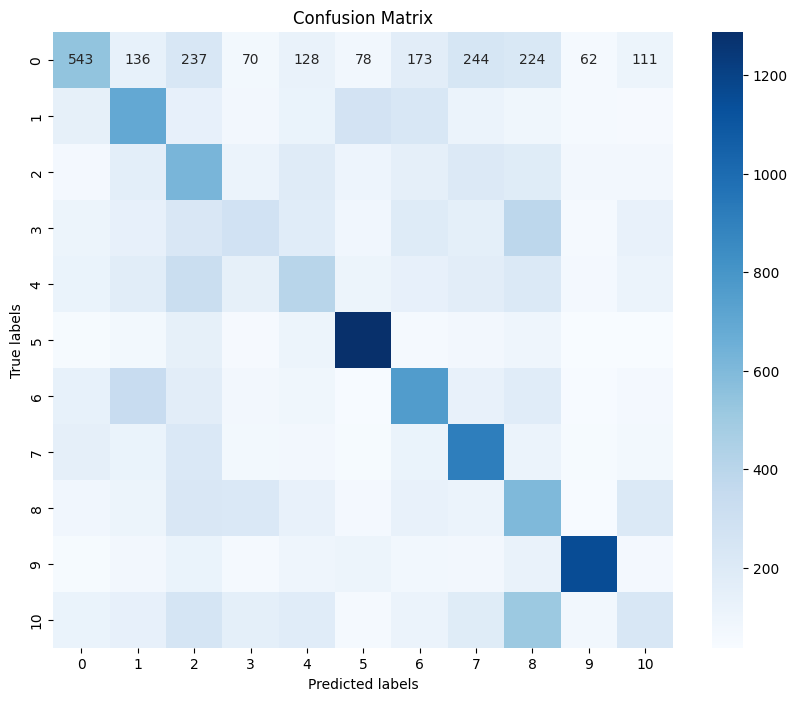

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_val, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", 
            xticklabels=range(11), yticklabels=range(11))
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

Map together from ideology

In [49]:
# Define a function to map individual labels to broader categories
def map_to_ideology(label):
    if label in [0, 1, 2, 3, 4]:   # Liberal
        return 'Liberal'
    elif label == 5:               # Neutral
        return 'Neutral'
    elif label in [6, 7, 8, 9, 10]: # Conservative
        return 'Conservative'
    else:
        raise ValueError(f"Unexpected label: {label}")

# Apply the mapping to your true labels and predictions
y_val_ideology = np.array([map_to_ideology(label) for label in y_val])
y_pred_ideology = np.array([map_to_ideology(label) for label in y_pred])


In [50]:
# Create a confusion matrix for the mapped labels
conf_matrix_ideology = confusion_matrix(y_val_ideology, y_pred_ideology, labels=['Liberal', 'Neutral', 'Conservative'])

print("Confusion Matrix (Mapped Ideologies):")
print(conf_matrix_ideology)

# Generate a classification report for the mapped labels
class_report_ideology = classification_report(y_val_ideology, y_pred_ideology)

print("Classification Report (Mapped Ideologies):")
print(class_report_ideology)

print("Validation accuracies concatenated")
val_accuracy_conc = np.mean(y_val_ideology == y_pred_ideology)
print(val_accuracy_conc)


Confusion Matrix (Mapped Ideologies):
[[5572  643 3728]
 [ 429 1288  312]
 [3496  330 6202]]
Classification Report (Mapped Ideologies):
              precision    recall  f1-score   support

Conservative       0.61      0.62      0.61     10028
     Liberal       0.59      0.56      0.57      9943
     Neutral       0.57      0.63      0.60      2029

    accuracy                           0.59     22000
   macro avg       0.59      0.60      0.60     22000
weighted avg       0.59      0.59      0.59     22000

Validation accuracies concatenated
0.5937272727272728


# Try With Densely Connected Neural Network

Entire Dataset

In [176]:
np_embedding = np.load("data/uncleaned_data/npy_BiasData_100-per-class-labels_paraphrase-MiniLM-L6-v2.npy")
JerryWeiData = pd.read_csv("data/uncleaned_data/JerryWeiAIData/train_orig.csv")
np_labels = np.array(JerryWeiData["label"])

Reduced Dataset

In [11]:
np_embedding = np.load("data/cleaned_data/npy_BiasData_100-per-class-SentenceEmbedding_paraphrase-MiniLM-L6-v2.npy")
np_labels = np.load("data/cleaned_data/npy_BiasData_100-per-class-labels_paraphrase-MiniLM-L6-v2.npy")

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NN(nn.Module):
    def __init__(self, in_features):
        super(NN, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Dropout(0.25),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(),
            nn.Dropout(0.25),
            nn.Linear(16, 10)  # Output layer with 10 units
        )

    def forward(self, x):
        output = self.classifier(x)
        # Apply softmax activation to get class probabilities
        return F.softmax(output, dim=1)

In [5]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        return feature, label

In [11]:
X_train, X_val, y_train, y_val = train_test_split(np_embedding,
                                                  np_labels,
                                                  test_size=0.2)

In [7]:
#training loop 
epochs = 100 
lr = 0.01 
bs = 8

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate model
model = NN(in_features=X_train.shape[1])
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

y_train_reshaped = y_train.reshape(-1, 1)
y_val_reshaped = y_val.reshape(-1, 1)

train_set = CustomDataset(X_train, y_train_reshaped)
test_set = CustomDataset(X_val, y_val_reshaped)

#train_set = np.concatenate([X_train, y_train_reshaped], axis = 1)
#test_set = np.concatenate([X_val, y_val_reshaped], axis = 1)

train_loader = DataLoader(train_set, batch_size=bs)
test_loader = DataLoader(test_set, batch_size=bs)

In [ ]:
training_accuracies = []
training_losses = []
testing_accuracies = []
testing_losses = []

for epoch in range(epochs):
    model.train()
    
    train_correct = 0
    total_train = 0
    train_loss_sum = 0

    start_time = time.time()

    for idx, (embedding, label) in enumerate(train_loader): 
        embedding, label = embedding.to(device), label.to(device).squeeze()  # Squeeze the label to remove the extra dimension
        y_pred = model(embedding)
        optimizer.zero_grad()

        train_loss = criterion(y_pred, label)
        train_loss_sum += train_loss.item()
        train_loss.backward()
        optimizer.step()

        _, predicted = torch.max(y_pred, dim=1)
        train_correct += (predicted == label).sum().item()
        total_train += label.size(0)
    
    avg_train_loss = train_loss_sum / len(train_loader)
    train_acc = train_correct / total_train
    training_accuracies.append(train_acc)
    training_losses.append(avg_train_loss)

    model.eval()
    test_correct = 0
    total_test = 0
    test_loss_sum = 0
    with torch.no_grad():
        for idx, (embedding, label) in enumerate(test_loader):
            embedding, label = embedding.to(device), label.to(device).squeeze()  # Squeeze the label to remove the extra dimension
            y_pred = model(embedding)
            test_loss = criterion(y_pred, label)
            test_loss_sum += test_loss.item()
            
            _, predicted = torch.max(y_pred, dim=1)
            test_correct += (predicted == label).sum().item()
            total_test += label.size(0)

    avg_test_loss = test_loss_sum / len(test_loader)
    test_acc = test_correct / total_test
    testing_losses.append(avg_test_loss)
    testing_accuracies.append(test_acc)

    print(f"Epoch: {epoch+1}/{epochs}, Time per Epoch: {time.time() - start_time:.2f}s, "
          f"Training Accuracy: {train_acc:.4f}, Testing Accuracy: {test_acc:.4f}, "
          f"Training Loss: {avg_train_loss:.4f}, Testing Loss: {avg_test_loss:.4f}")

# Visualize Word Embeddings

In [51]:
np_embedding = np.load("data/cleaned_data/npy_BiasData_10000_sentence_embedding_BERT.npy")
np_labels = np.load("data/cleaned_data/npy_BiasData_10000_labels_BERT.npy")

In [61]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
pca.fit(np_embedding)
pca_embedding = pca.transform(np_embedding)

In [63]:
from sklearn.manifold import TSNE

embeddings = pca_embedding
labels = np_labels
# Step 3: Apply T-SNE
# Initialize T-SNE with desired parameters
tsne = TSNE(n_components=2, perplexity=20, n_iter=5000, random_state=42)

# Reduce dimensionality
tsne_results = tsne.fit_transform(embeddings)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f1decd6b400>
Traceback (most recent call last):
  File "/home/carlviggo/anaconda3/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/carlviggo/anaconda3/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/carlviggo/anaconda3/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/carlviggo/anaconda3/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


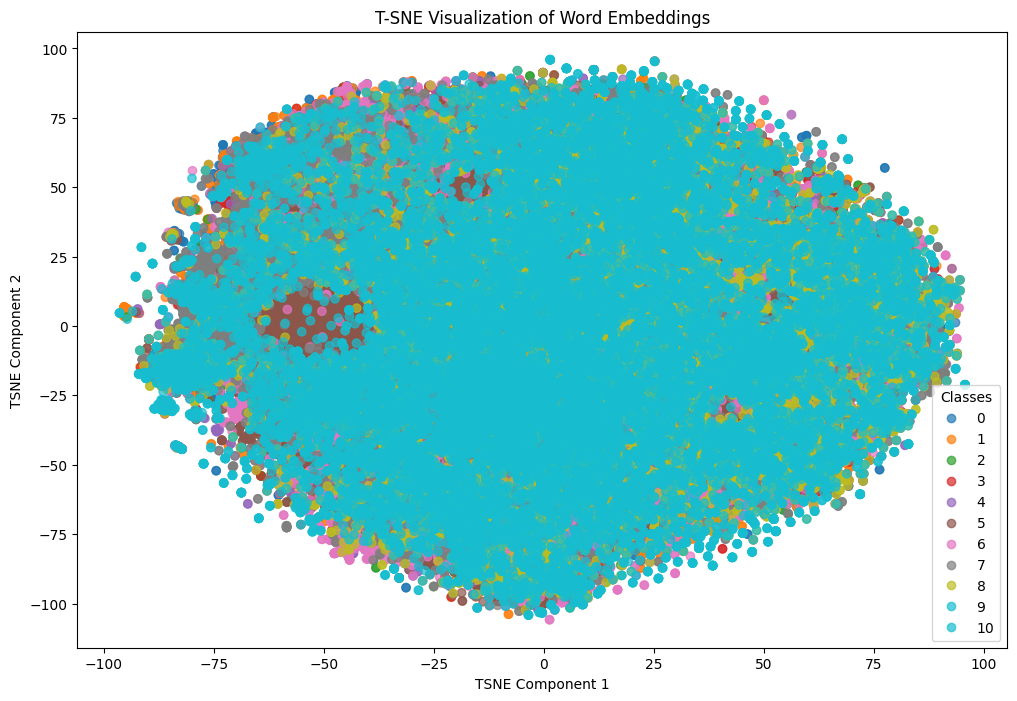

In [60]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='tab10', alpha=0.7)

# Create a legend for classes
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")

# Add labels and title
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.title("T-SNE Visualization of Word Embeddings")

# Show plot
plt.show()

Try with Slisemap instead of TSNE

In [ ]:
import numpy as np
from slisemap import Slisemap
import matplotlib.pyplot as plt

# Load your embeddings and labels
embeddings = np.load('path_to_your_embeddings.npy')  # Replace with your path
labels = np.load('path_to_your_labels.npy')  # Replace with your path

# Ensure embeddings and labels are in the correct format
embeddings = np.array(embeddings)
labels = np.array(labels)

# Initialize Slisemap
smap = Slisemap(embeddings, y=labels, perplexity=30, verbose=True)

# Fit the model
smap.fit(n_iter=3000)

# Plot the 2D embedding
smap.plot(show=True)

# Save the plot to a file
plt.savefig('slisemap_visualization.png')

# Get the local linear model for a specific point
local_model = smap.local_model(point_index=0)  # Replace 0 with the desired index
print("Local Model Coefficients:", local_model.coef_)
